# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### Step 2 - Import libraries and data
#### Step 3 - Subset, wrangle, and clean time-series data
#### Step 4 - Create a line chart of the data
#### Step 5 - Decompose the data's components
#### Step 6 - Check for stationarity
#### Step 7 - Conduct a round of differencing on the data
#### Step 8 - Perform another round of differencing
#### Step 9 - Check the data's autocorrelations

### Step 2 - Import libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'XsScAQ1iNfB526v6ep5a'

In [3]:
# Importing the Zillow Data variables.

data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id='99999')

In [4]:
data.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2023-08-31,487125.108603
1,ZSFH,99999,2023-07-31,488622.145790
2,ZSFH,99999,2023-06-30,488664.469915
3,ZSFH,99999,2023-05-31,487177.043727
4,ZSFH,99999,2023-04-30,483911.059168


### Step 3 - Subset, wrangle, and clean time-series data

In [5]:
data_sub = data.loc[(data['date'] < '2023-10-01')]

In [6]:
data_sub.shape

(224, 4)

In [7]:
data_sub.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2023-08-31,487125.108603
1,ZSFH,99999,2023-07-31,488622.145790
2,ZSFH,99999,2023-06-30,488664.469915
3,ZSFH,99999,2023-05-31,487177.043727
4,ZSFH,99999,2023-04-30,483911.059168


Reason for subsetting the data was to make sure there were no forecasted values, of which I saw no evidence since the shape remained the same.

In [8]:
# Create a data frame with just the date and the values columns

data_to_plot = data_sub[['date','value']]
data_to_plot.head()

,date,value
None,,
0,2023-08-31,487125.108603
1,2023-07-31,488622.145790
2,2023-06-30,488664.469915
3,2023-05-31,487177.043727
4,2023-04-30,483911.059168


In [9]:
# Check shape

data_to_plot.shape

(224, 2)

In [10]:
# Set the "date" column as the index

from datetime import datetime

data_to_plot['datetime'] = pd.to_datetime(data_to_plot['date']) # Create a datetime column from "date."
data_to_plot = data_to_plot.set_index('datetime') # Set the datetime as the index of the dataframe.
data_to_plot.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_to_plot.head()

,value
datetime,
2023-08-31,487125.108603
2023-07-31,488622.145790
2023-06-30,488664.469915
2023-05-31,487177.043727
2023-04-30,483911.059168


In [11]:
# Check for missing values (you shouldn't have any)

data_to_plot.isnull().sum() 

value    0
dtype: int64

In [12]:
# Check for duplicates

dups = data_to_plot.duplicated()
dups.sum()

# No duplicates

0

### Step 4 - Create a line chart of the data

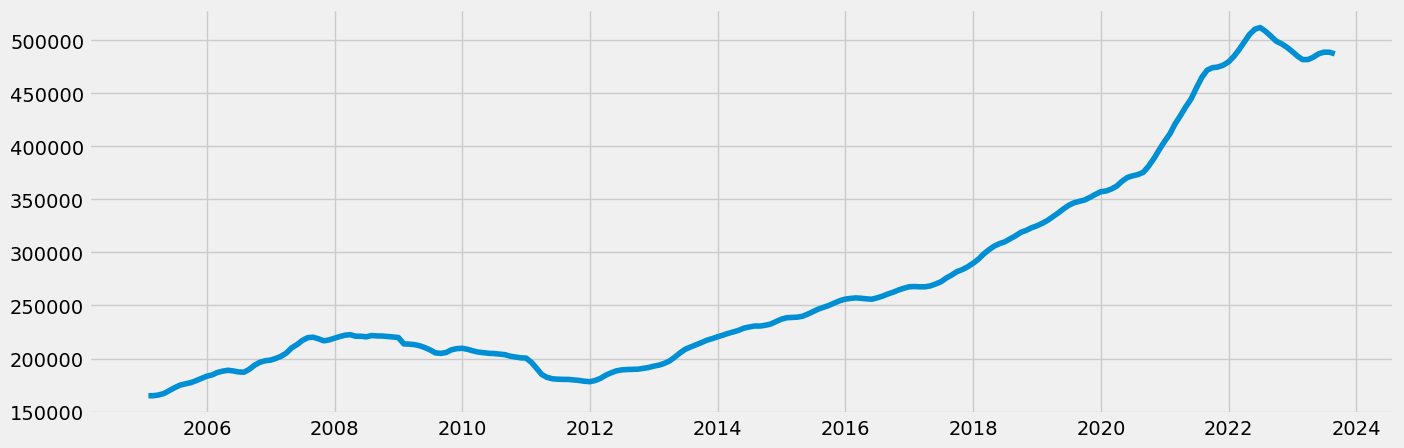

In [13]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_to_plot)

### Step 5 - Decompose the data's components

In [14]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_to_plot, model='additive')

In [15]:
# This will define a fixed size for all special charts.

from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

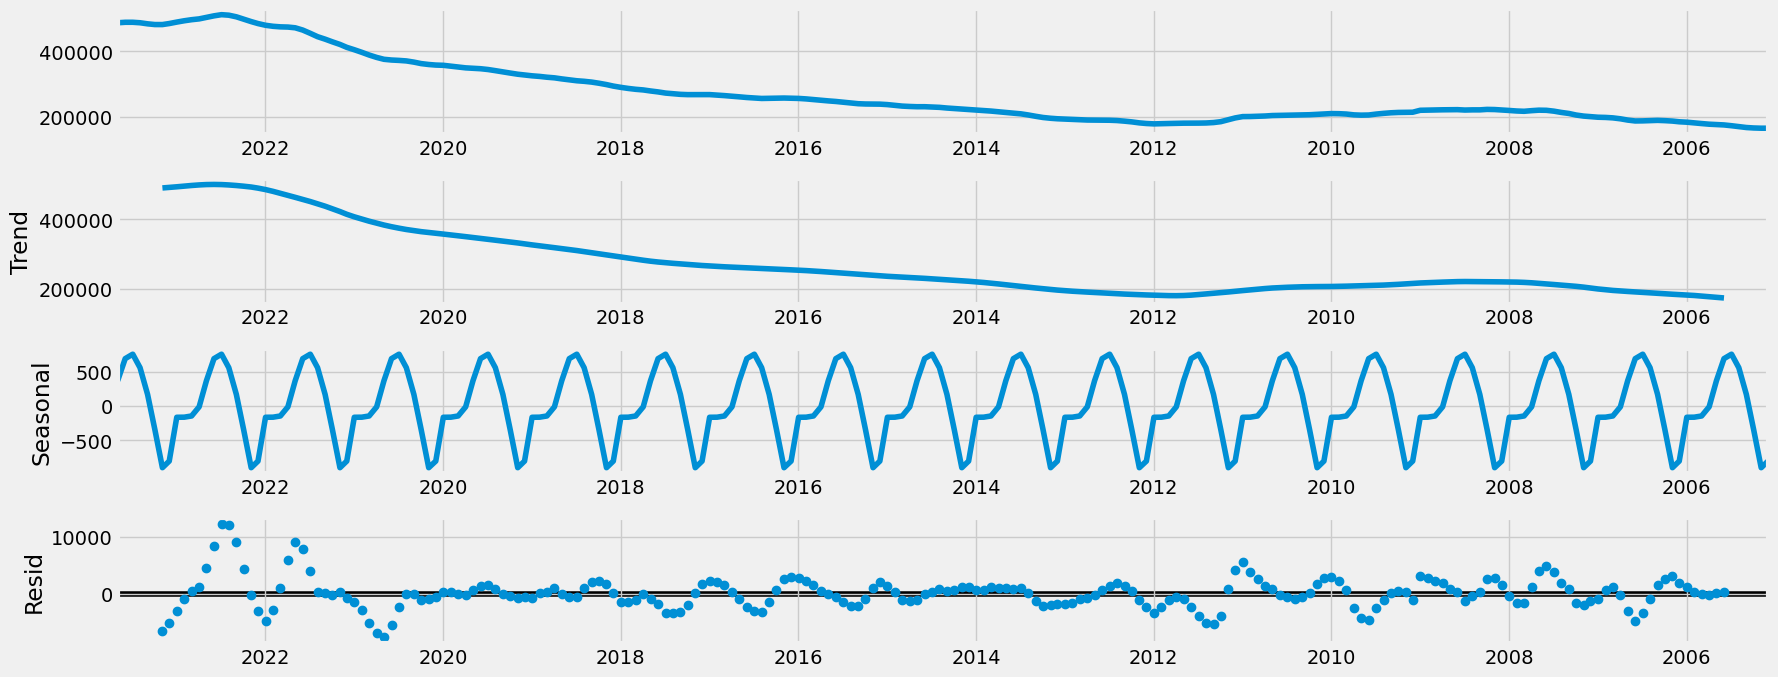

In [16]:
# Plot the separate components

decomposition.plot()
plt.show()

Analysis of the decomposition plot results:

The level (1st chart) - the data itself does not show much noise

The trend (2nd chart) - appears the same as the level because there is not much noise in the data itself; the overall dominant trend continues to increase until 2022 and then levels out until the present year

The seasonality (3rd chart) - shows seasonal fluctuations that change at a regular interval

The residual (4th chart) - there is minimal noise from 2006 - 2020 and then the increase in home prices in recent years is reflected by the larger fluctuations shown from 2020 - present

### Step 6 - Check for stationarity

In [17]:
# Import the adfuller() function

from statsmodels.tsa.stattools import adfuller

# Define a function that prints the correct output from that array.

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_to_plot['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.037990
p-value                          0.270168
Number of Lags Used              4.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


Interpretation of the results (reference the null hypothesis):

The p-value does not indicate that the test result is significant, as it is not less than 0.05.

The test statistic is larger than all 3 of the critical values, and the null hypothesis cannot be rejected, which means that there is a unit root in the data, and that the data is thereby non-stationary and has a trend.

Since forecasting cannot be done with non-stationary data, the data will need to be made stationary.

In order to make the data stationary, a technique(s) will have to be used to extract the trend from the ddata by removing any unnecessary variance.  Differencing will be conducted below.

### Step 7 - Conduct a round of differencing on the data

In [18]:
data_diff = data_to_plot - data_to_plot.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [19]:
# Remove the missing values that came about as a result of the differencing

data_diff.dropna(inplace = True) 

In [20]:
data_diff.head()

,value
datetime,
2023-07-31,1497.037187
2023-06-30,42.324125
2023-05-31,-1487.426188
2023-04-30,-3265.984558
2023-03-31,-2209.843924


In [21]:
data_diff.columns

Index(['value'], dtype='object')

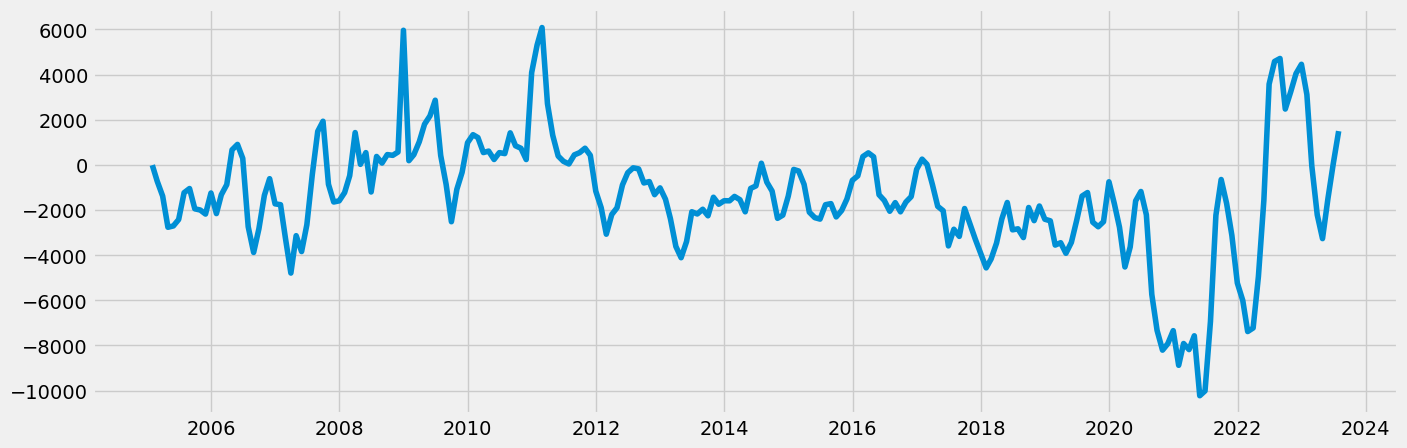

In [22]:
# Check what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [23]:
# Conduct the Dickey-Fuller test to check for stationarity again

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.339628
p-value                          0.013197
Number of Lags Used              3.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


The process to stationarize the data was a success: 

The test statistic is now smaller than the critical value at both the five and ten percent significance levels.  

I also have a satsifactory p-value (p<0.05).

This means that I can reject the null hypothesis and, as a result, consider my series stationary.

### Step 8 - Perform another round of differencing

There is no need, as the the data is now stationary.

### Step 9 - Check the data's autocorrelations

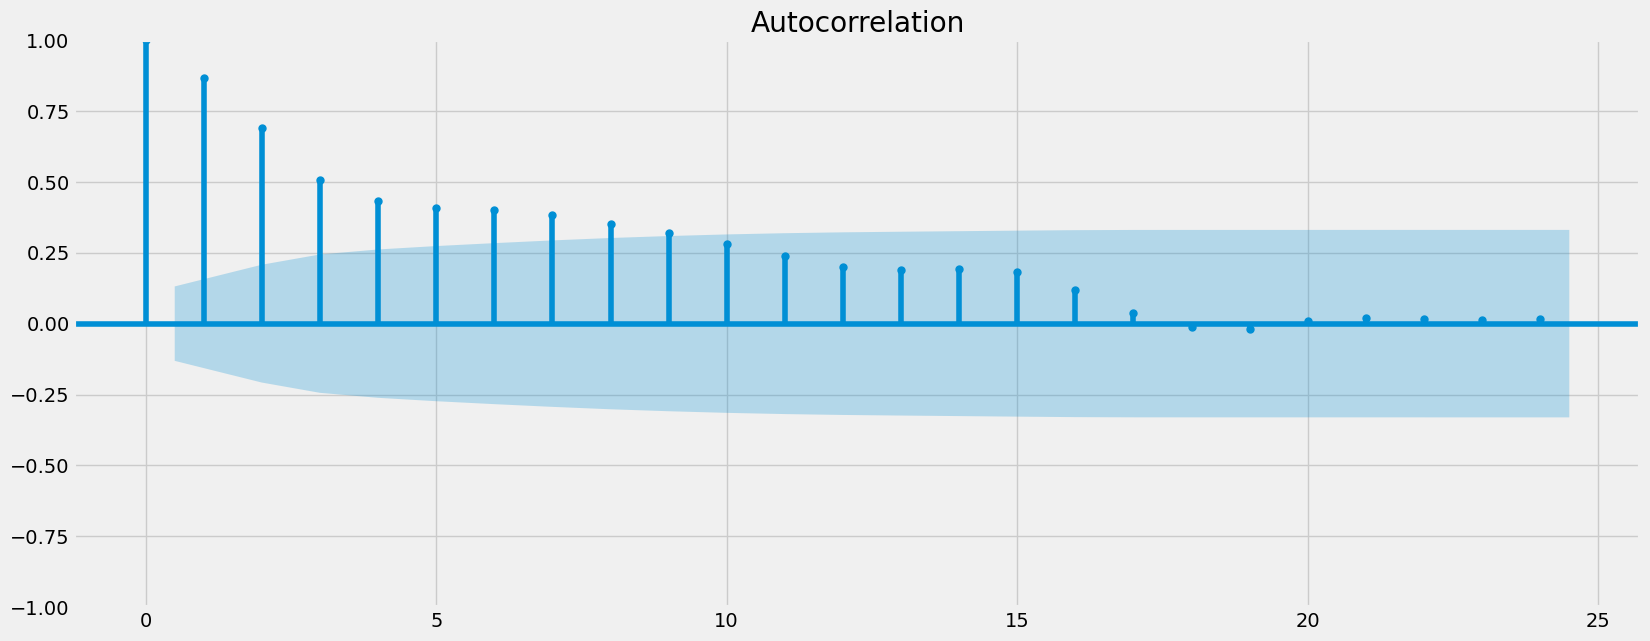

In [24]:
# Import the autocorrelation and partial correlation plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()

The autocorrelation graph shows that there are not that many lags above the blue edge of the confidence interval.  Although the stationarity is weak, because the Dickey-Fuller test proved the data to be stationary and the 10th significant lag was basically right on the edge of the blue confidence interval, I didn't find it necessary to conduct another round of differencing.  